In [ ]:
# default_exp core

# Ocetrac

> Track and label marine heatwaves from geospatial data. 

In [ ]:
#hide
from nbdev.showdoc import *
import xarray as xr
import numpy as np
import scipy.ndimage

## Functions

In [ ]:
#hide
def _morphological_operations(data, include_poles=False, radius=8): 
    '''Converts data to binary, defines structuring element, and performs morphological closing then opening'''
    if include_poles==False:
        bitmap = data.where((data.lat<65) & (data.lat>-70), drop=False, other=np.nan) # Turn data poleward of 65ºN and 70ºS to NaNs
    
    # Convert to binary
    bitmap_binary = bitmap.where(bitmap>0, drop=False, other=0)
    bitmap_binary = bitmap_binary.where(bitmap_binary==0, drop=False, other=1)
                   
    # Define tructuring element
    diameter = radius*2
    x = np.arange(-radius, radius+1)
    x, y = np.meshgrid(x, x)
    r = x**2+y**2 
    se = r<radius**2
                              
    mo_data = xr.DataArray(None, dims=bitmap_binary.dims, coords=bitmap_binary.coords)
    pad_data = bitmap_binary.pad(lat=(diameter, diameter), lon=(diameter, diameter), mode='constant', constant_values=0)
    
    if data.ndim == 3:
        for i in range(mo_data.shape[0]): # ! remove explicit loops
            S1 = scipy.ndimage.binary_closing(pad_data[i,:,:], se, iterations=1) # ! can include mask option
            S2 = scipy.ndimage.binary_opening(S1, se, iterations=1)
            S2 = xr.DataArray(S2[diameter:-diameter, diameter:-diameter],
                              dims=['lat','lon'],
                              coords={'lat':bitmap_binary.lat,
                                      'lon':bitmap_binary.lon})
            mo_data[i,:,:] = S2
        else:
            S1 = scipy.ndimage.binary_closing(pad_data, se, iterations=1) # ! can include mask option
            S2 = scipy.ndimage.binary_opening(S1, se, iterations=1)
            S2 = xr.DataArray(S2[diameter:-diameter, diameter:-diameter],
                              dims=['lat','lon'],
                              coords={'lat':bitmap_binary.lat,
                                      'lon':bitmap_binary.lon})
            mo_data = S2

    mo_binary = xr.DataArray(mo_data, dims=bitmap_binary.dims, coords=bitmap_binary.coords)
    return mo_binary


In [ ]:
#hide 
# Test for _morphological_operations()

lon = np.arange(0, 360) + 0.5
lat = np.arange(-90, 90) + 0.5
x, y = np.meshgrid(lon, lat)

x0 = 180; x1 = 225; x2 = 360; x3 = 1; x4 = 80
y0 = 0; y1 = 20; y2 = -50; y4 = 40
sigma0 = 10; sigma1 = 25; sigma2 = 30; sigma4 = 10

blob0 = np.exp(-((x - x0)**2 + (y - y0)**2)/(2*sigma0**2))
blob1 = np.exp(-((x - x1)**2 + (y - y1)**2)/(2*sigma1**2))
blob2 = np.exp(-((x - x2)**2 + (y - y2)**2)/(2*sigma2**2))
blob3 = np.exp(-((x - x3)**2 + (y - y2)**2)/(2*sigma2**2))
blob4 = np.exp(-((x - x4)**2 + (y - y4)**2)/(2*sigma4**2))

da = xr.DataArray((blob0+blob1+blob2+blob3+blob4)-.5, dims=['lat', 'lon'],
                  coords={'lat': lat, 'lon': lon})


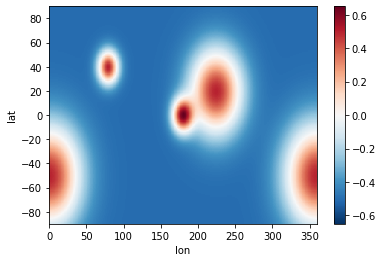

In [ ]:
da.plot()

In [ ]:
mo_binary = _morphological_operations(da, include_poles=False, radius=5)



ValueError: different number of dimensions on data and dims: 1 vs 2

2D Gaussian-like array:


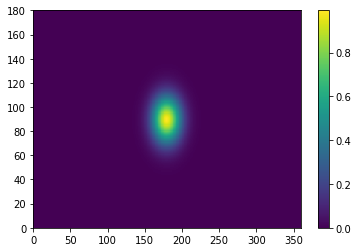

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

lon = np.arange(0, 360) + 0.5
lat = np.arange(-90, 90) + 0.5
x, y = np.meshgrid(lon, lat)

x0 = 180; x1 = 225; x2 = 360; x3 = 1; x4 = 80
# y0 = 0; y1 = 20; y2 = -50; y4 = 40
# sigma0 = 20; sigma1 = 30; sigma2 = 40; sigma4 = 10

# blob0 = np.exp(-((x - x0)**2 + (y - y0)**2)/sigma0**2)


x, y = np.meshgrid(lon, lat)
f = np.sqrt((x - x0)**2+(y - y0)**2)
sigma, mu = 20, 0.0
g = np.exp(-( (f-mu)**2 / ( 2*sigma**2 ) ) )
print("2D Gaussian-like array:")
plt.pcolormesh(g); plt.colorbar()


1.44592180551781e-22

In [ ]:
mo_binary = _morphological_operations(da, include_poles=False, radius=5)

In [ ]:
# Convert to binary
bitmap_binary = da.where(da>0, drop=False, other=0)
bitmap_binary = bitmap_binary.where(bitmap_binary==0, drop=False, other=1)
                   
# # Define tructuring element
# radius=1
# diameter = radius*2
# x = np.arange(-radius, radius+1)
# x, y = np.meshgrid(x, x)
# r = x**2+y**2 
# se = r<radius**2
                              
# mo_data = xr.DataArray(None, dims=bitmap_binary.dims, coords=bitmap_binary.coords)
# pad_data = bitmap_binary.pad(lat=(diameter, diameter), lon=(diameter, diameter), mode='constant', constant_values=0)
    
# for i in range(mo_data.shape[0]): # ! remove explicit loops
#     S1 = scipy.ndimage.binary_closing(pad_data[i,:,:], se, iterations=1) # ! can include mask option
#     S2 = scipy.ndimage.binary_opening(S1, se, iterations=1)
#     S2 = xr.DataArray(S2[diameter:-diameter, diameter:-diameter],
#                           dims=['lat','lon'],
#                           coords={'lat':bitmap_binary.lat,
#                                   'lon':bitmap_binary.lon})
#     mo_data[i,:,:] = S2
# mo_binary = xr.DataArray(mo_data, dims=bitmap_binary.dims, coords=bitmap_binary.coords)


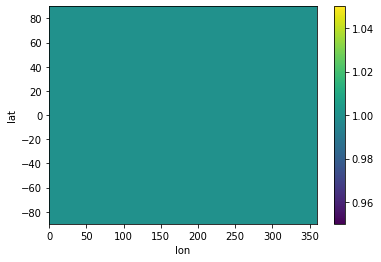

In [ ]:
bitmap_binary.plot()

In [ ]:
#hide
def _wrap_labels(labels_2D):
    '''wrap labels that cross prime meridian '''

    prime = labels_2D.loc[dict(lon=labels_2D.lon[:2])]

    prime_ids = np.unique(prime)[~np.isnan(np.unique(prime))].astype('int')
    mirrormapBool = xr.DataArray(np.in1d(id_1, prime_ids).reshape(id_1.shape),
                                 dims=labels_2D.dims,
                                 coords=labels_2D.coords)
    earth2 = labels_2D.where(mirrormapBool==True, drop=False, other=np.nan)
    earth1 = labels_2D.where(mirrormapBool==False, drop=False, other=np.nan) # Remove label from origonal map
    
    # Concatenate and convert to binary
    res = labels_2D.lon[1].values-labels_2D.lon[0].values # resolution of longitude
    two_earths = xr.concat([earth1, earth2], dim='lon')
    two_earths['lon'] = np.arange(float(da.lon[0].values),(two_earths.lon[-1].values*2)+res,res)
    bitmap_binary_2E = two_earths.where(two_earths>0, drop=False, other=0)
    bitmap_binary_2E = bitmap_binary_2E.where(bitmap_binary_2E==0, drop=False, other=1)
    bitmap_bool_2E = bitmap_binary_2E>0
    
    return bitmap_binary_2E, bitmap_bool_2E

In [ ]:
#hide
def _id(binary_images):
    '''label 2D features from binary images'''
    labels = np.zeros_like(binary_images)
    for i in range(labels.shape[0]):
        L = label_sk(binary_images[i,:,:], connectivity=2, return_num=True)
        L = xr.DataArray(L[0], dims=['lat', 'lon'],
                         coords={'lat':binary_images.lat, 'lon':binary_images.lon})
        L = L.where(L>0, drop=False, other=np.nan)
        if i == 0:
            labels[i,:,:] = L
        if i == 1:
            maxl = np.nanmax(labels[i-1,:,:])
            if np.isnan(maxl):
                labels[i,:,:] = L+0
            else:
                labels[i,:,:] = L+maxl
        else:
            maxl = np.nanmax(labels[:i-1,:,:])
            if np.isnan(maxl):
                labels[i,:,:] = L+0
            else:
                labels[i,:,:] = L+maxl
            
    id_2D = xr.DataArray(labels, dims=binary_images.dims, coords=binary_images.coords)
    id_2D = id_2D.where(id_2D!=0, drop=False, other=np.nan)
    
    return id_2D

In [ ]:
#hide
def _id_area(labels_2D, min_size_quartile):
    '''calculatre area with regionprops'''
    
    props = regionprops(labels_2D.astype('int').values)

    labelprops = [p.label for p in props]
    labelprops = xr.DataArray(labelprops, dims=['label'], coords={'label': labelprops}) 
    coords = [p.coords for p in props] # time, lat, lon

    area = []
    res = labels_2D.lat[1].values-labels_2D.lat[0].values # resolution of latitude
    for i in range(len(coords)):  
        area.append(np.sum((res*111)*np.cos(np.radians(labels_2D.lat[coords[i][:,1]].values)) * (res*111)))
        area = xr.DataArray(area, dims=['label'], coords={'label': labelprops})  
    min_area = np.percentile(area, min_size_quartile*100)
    print('min area (km2) \t', min_area)  
    
    return area, min_area, labelprops

In [ ]:
#export
def label(da):
    '''2D image labeling
    
    Parameters
    ----------
    da : xarray.DataArray
        The data to label
        
    Returns
    -------
    labels : xarray.DataArray
        Integer labels of connected regions.
    '''
        
    # Converts data to binary, defines structuring element, and performs morphological closing then opening
    mo_binary = _morphological_operations(data, include_poles=False, radius=8) 
    
    # label 2D features from binary images
    id_2D = _id(binary_images)

    # wrap labels that cross prime meridian
    bitmap_binary_2E, bitmap_bool_2E = _wrap_labels(id_2D)
    
    ### ! Reapply land maks HERE
    
    # relabel 2D features from binary images that are wrapped around meridian
    id_2D_wrap = _id(bitmap_binary_2E)
    
    # Convert labels to DataArray
    id_2D_wrap = xr.DataArray(id_2D_wrap, 
                              dims=bitmap_bool_2E.dims, 
                              coords=bitmap_bool_2E.coords)
    id_2D_wrap = id_2D_wrap.where(id_2D_wrap!= 0, drop=False, other=np.nan)

    # calculatre area with regionprops
    area, min_area, labelprops = _id_area(id_2D_wrap, .75)
    
    keep_labels = labelprops.where(area>=min_area, drop=True)

    id_2D_area_bool = xr.DataArray(np.in1d(id_2D_wrap, keeplabels).reshape(id_2D_wrap.shape),
                            dims=id_2D_wrap.dims, coords=id_2D_wrap.coords)
    
    # Calculate Percent of total MHW area retained
    tot_area = int(np.sum(area.values))
    small_area = area.where(area<=min_area, drop=True)
    small_area = int(np.sum(small_area.values))
    percent_area_kept = 1-(small_area/tot_area)

    
#     num_2D_features = np.nanmax(keep_labels.values)  
#     print('Number of 2D labeled features = \t', num_2D_features)

    ds_out = id_2D_area_bool.rename('labels')
    ds_out.attrs['min_area'] = min_area
    ds_out.attrs['percent_area_kept'] = percent_area_kept
    
    return ds_out

`label` lets us identify marine heatwaves as 2-dimensional objects using morphological image processing. Let's run through an example using the NOAA Optimum Interpolation Sea Surface Temperature (OISST) dataset. We are using data that had been preprocessed as to keep only those anomalies that exceed the 90th percentile with respect to the 1981-2020 monthly climatology. 

Let's test `_check_input` to make sure that our data is either an `xr.DataArray` or `xr.Dataset`

In [ ]:
# import xarray as xr
# import numpy as np

# data_array = xr.DataArray(np.random.rand(5,3,3), dims=['time','lat','lon'], name='test',
#                           coords={'time': np.random.rand(5),
#                                   'lat': np.random.rand(3),
#                                   'lon': np.random.rand(3)})

# data_out = _check_input(data_array,'test')
# assert type(data_out)==xr.core.dataarray.DataArray or type(data_out)==xr.core.dataarray.Dataset


In [ ]:
#export
def track(da):
    '''Track labeled features
        
    Parameters
    ----------
    da : xarray.DataArray
        The data in which to track features
        
    Returns
    -------
    tracked : xarray.DataArray
        Integer labels of tracked regions.
    '''
    
    ####### Label with Skimage
    # relabel
    label_sk3, final_features = label_sk(data, connectivity=3, return_num=True)

    # Convert labels to DataArray
    mhw_id_3 = xr.DataArray(label_sk3, dims=['time','lat','lon'],
                                 coords={'time': data.time, 'lat': data.lat,'lon': data.lon})
    mhw_id_3 = mhw_id_3.where(mhw_id_3 != 0, drop=False, other=np.nan)

    print('final features \t', final_features)

    dataout = mhw_id_3.rename('labels')
    dataout.attrs['total MHWs'] = final_features
    dataout.attrs['minimum size (km2)'] = data.attrs['min_area']
#     dataout.attrs['minimum size percentile'] = min_size_quartile
    dataout.attrs['fraction of total MHW area kept'] = data.attrs['percent_area_kept']
#     dataout.attrs['temperature threshold percentile'] = threshold
#     dataout.attrs['morphological radius'] = radius
#     dataout.attrs['connectivity'] = connectivity
#     dataout.attrs['resolution'] = res

#     out_path = '/glade/scratch/scanh/MHW_labels/'
#     dataout.to_netcdf(out_path + 'MHWlabels_monthly_OISST_' + outnetCDF, mode='w')

    return dataout


In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()
# this is the same as running nbdev_build_lib